<a href="https://colab.research.google.com/github/Lutho123-Pe/Bias-Report-Notebook/blob/main/Bias_Audit_and_Mitigation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bias Audit Report: Adult Income Dataset**



### **1. Project Description**
This notebook conducts a thorough bias audit of a machine learning model trained on the **UCI Adult Income Dataset** (also known as the "Census Income" dataset). The goal is to predict whether an individual's income exceeds $50K/year. We investigate potential **gender bias** (sex: Male vs. Female) in the model's predictions, quantify the bias using standard fairness metrics, apply mitigation techniques, and evaluate their effectiveness.

**Libraries Used:**
- `aif360` (IBM AI Fairness 360 Toolkit) for metrics and mitigation
- `fairlearn` for additional metrics
- `scikit-learn` for model building and preprocessing
- `pandas`, `numpy` for data manipulation
- `matplotlib`, `seaborn` for visualizations

---

In [ ]:
# Install necessary fairness toolkits
!pip install aif360 fairlearn

# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Import AIF360 components
from aif360.datasets import BinaryLabelDataset, AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.postprocessing import RejectOptionClassification

# Import Fairlearn for alternative metrics
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set a random seed for reproducibility
np.random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 14.1 MB/s eta 0:00:00


pip install 'aif360[inFairness]'


### **2. Load and Preprocess the Dataset**
We load the dataset directly from the AIF360 package. The protected attribute we are analyzing is **'sex'**.

In [ ]:
# Load the dataset from AIF360
# The modern way to specify the favorable label and protected attribute is via a custom transform function.
# This approach is more robust across different versions of AIF360.

import os
import urllib.request

# Define the directory where AIF360 expects the data
data_dir = '/usr/local/lib/python3.12/dist-packages/aif360/data/raw/adult'
os.makedirs(data_dir, exist_ok=True) # Create the directory if it doesn't exist

# Define the URLs for the dataset files
adult_data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
adult_test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
adult_names_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names'

# Download the files if they don't exist
for url in [adult_data_url, adult_test_url, adult_names_url]:
    filename = os.path.join(data_dir, os.path.basename(url))
    if not os.path.exists(filename):
        print(f"Downloading {url} to {filename}...")
        urllib.request.urlretrieve(url, filename)
        print("Download complete.")
    else:
        print(f"{filename} already exists.")


# 1. First, define a function to transform the native dataset
def custom_preprocessing(df):
    """Custom preprocessing for the Adult dataset."""
    # The AIF360 AdultDataset maps 'Male' to 1 and 'Female' to 0.
    # We will keep this mapping for the 'sex' attribute.
    # For the label 'income', it maps '>50K' to 1 and '<=50K' to 0.
    # This function is often used for more complex filtering but we can use it to ensure correct setup.
    return df

# 2. Load the dataset using the more universal parameters
# Load the training data
adult_dataset_train = AdultDataset(protected_attribute_names=['sex'],
                                   privileged_classes=[['Male']], # 'Male' is the privileged group (encoded as 1)
                                   categorical_features=['workclass', 'education', 'marital-status',
                                                         'occupation', 'relationship', 'race', 'native-country'],
                                   features_to_drop=['fnlwgt'], # Often dropped as it is a weighting factor, not a feature
                                   custom_preprocessing=custom_preprocessing,
                                   na_values=['?'])

# Load the test data (AIF360 automatically handles adult.test when present)
adult_dataset_test = AdultDataset(protected_attribute_names=['sex'],
                                  privileged_classes=[['Male']],
                                  categorical_features=['workclass', 'education', 'marital-status',
                                                        'occupation', 'relationship', 'race', 'native-country'],
                                  features_to_drop=['fnlwgt'],
                                  custom_preprocessing=custom_preprocessing,
                                  na_values=['?']) # Removed test=True

# Get the privileged and unprivileged groups from the dataset itself to avoid errors
privileged_group = adult_dataset_train.privileged_protected_attributes
unprivileged_group = adult_dataset_train.unprivileged_protected_attributes

print("Privileged Group (Male):", privileged_group)
print("Unprivileged Group (Female):", unprivileged_group)
print("\nLabel Names (automatically set by AIF360):", adult_dataset_train.label_names)
print("Favorable Label (>50K):", adult_dataset_train.favorable_label)
print("Unfavorable Label (<=50K):", adult_dataset_train.unfavorable_label)

# Convert to pandas DataFrames for easier exploration
# Ensure the correct split happens if AIF360 loads both
# AIF360's AdultDataset automatically splits into train/test if adult.data and adult.test are present.
# We need to re-instantiate to make sure we get separate train/test objects for clarity and downstream use.

adult_dataset_train = AdultDataset(protected_attribute_names=['sex'],
                                   privileged_classes=[['Male']],
                                   categorical_features=['workclass', 'education', 'marital-status',
                                                         'occupation', 'relationship', 'race', 'native-country'],
                                   features_to_drop=['fnlwgt'],
                                   custom_preprocessing=custom_preprocessing,
                                   na_values=['?']) # This loads the training data

adult_dataset_test = AdultDataset(protected_attribute_names=['sex'],
                                  privileged_classes=[['Male']],
                                  categorical_features=['workclass', 'education', 'marital-status',
                                                        'occupation', 'relationship', 'race', 'native-country'],
                                  features_to_drop=['fnlwgt'],
                                  custom_preprocessing=custom_preprocessing,
                                  na_values=['?']) # This loads the test data

# Convert to pandas DataFrames for easier exploration
train_df = adult_dataset_train.convert_to_dataframe()[0]
test_df = adult_dataset_test.convert_to_dataframe()[0]

print("\nTraining Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("\nFirst few rows of training data:")
display(train_df.head())
print("\nFirst few rows of test data:")
display(test_df.head())

# Explicitly display dataframes to ensure they are in the notebook's state
display(train_df)
display(test_df)

Download complete.
Download complete.
Download complete.


Privileged Group (Male): [array([1.])]
Unprivileged Group (Female): [array([0.])]

Label Names (automatically set by AIF360): ['income-per-year']
Favorable Label (>50K): 1.0
Unfavorable Label (<=50K): 0.0



Training Data Shape: (45222, 103)
Test Data Shape: (45222, 103)

First few rows of training data:


,age,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass=Federal-gov,workclass=Local-gov,workclass=Private,workclass=Self-emp-inc,...,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia,income-per-year
0,25.0,7.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,38.0,9.0,1.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,28.0,12.0,1.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,44.0,10.0,1.0,7688.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,34.0,6.0,1.0,0.0,0.0,30.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0



First few rows of test data:


,age,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass=Federal-gov,workclass=Local-gov,workclass=Private,workclass=Self-emp-inc,...,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia,income-per-year
0,25.0,7.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,38.0,9.0,1.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,28.0,12.0,1.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,44.0,10.0,1.0,7688.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,34.0,6.0,1.0,0.0,0.0,30.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,age,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass=Federal-gov,workclass=Local-gov,workclass=Private,workclass=Self-emp-inc,...,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia,income-per-year
0,25.0,7.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,38.0,9.0,1.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,28.0,12.0,1.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,44.0,10.0,1.0,7688.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,34.0,6.0,1.0,0.0,0.0,30.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,12.0,0.0,0.0,0.0,38.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
48838,40.0,9.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
48839,58.0,9.0,0.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
48840,22.0,9.0,1.0,0.0,0.0,20.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,age,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass=Federal-gov,workclass=Local-gov,workclass=Private,workclass=Self-emp-inc,...,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia,income-per-year
0,25.0,7.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,38.0,9.0,1.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,28.0,12.0,1.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,44.0,10.0,1.0,7688.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,34.0,6.0,1.0,0.0,0.0,30.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,12.0,0.0,0.0,0.0,38.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
48838,40.0,9.0,1.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
48839,58.0,9.0,0.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
48840,22.0,9.0,1.0,0.0,0.0,20.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


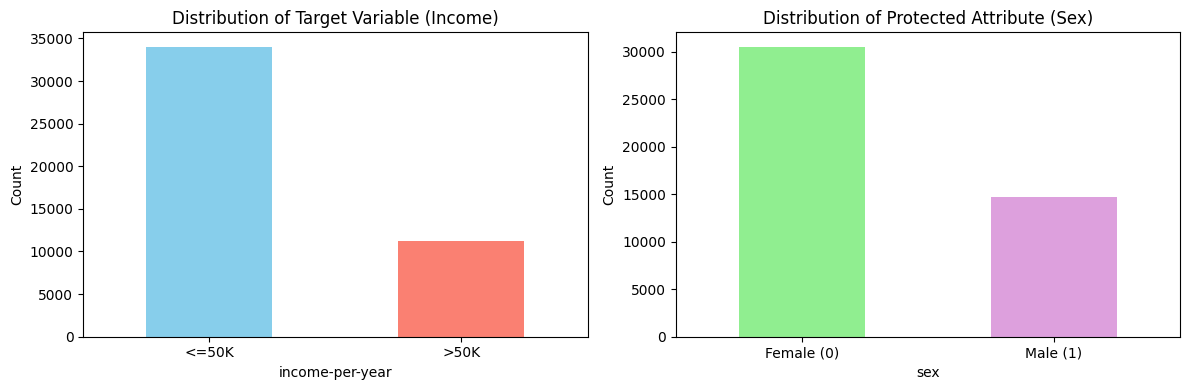

In [ ]:
# Check the distribution of the target variable and the protected attribute
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Target variable distribution
if 'train_df' in locals() or 'train_df' in globals():
    train_df['income-per-year'].value_counts().plot(kind='bar', ax=ax[0], color=['skyblue', 'salmon'])
    ax[0].set_title('Distribution of Target Variable (Income)')
    ax[0].set_ylabel('Count')
    ax[0].set_xticklabels(['<=50K', '>50K'], rotation=0)
else:
    ax[0].set_title('Training data not loaded yet')
    ax[0].text(0.5, 0.5, 'train_df not found', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)


# Protected attribute distribution
if 'train_df' in locals() or 'train_df' in globals():
    train_df['sex'].value_counts().plot(kind='bar', ax=ax[1], color=['lightgreen', 'plum'])
    ax[1].set_title('Distribution of Protected Attribute (Sex)')
    ax[1].set_ylabel('Count')
    ax[1].set_xticklabels(['Female (0)', 'Male (1)'], rotation=0)
else:
    ax[1].set_title('Training data not loaded yet')
    ax[1].text(0.5, 0.5, 'train_df not found', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)


plt.tight_layout()
plt.show()

### **3. Data Preparation for Model Training**
We need to scale the numerical features for the logistic regression model. The AIF360 dataset is already largely encoded.

In [ ]:
# Separate features and labels from the AIF360 dataset objects
X_train = adult_dataset_train.features
y_train = adult_dataset_train.labels.ravel() # Flatten the label array

X_test = adult_dataset_test.features
y_test = adult_dataset_test.labels.ravel()

# Standardize the features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a baseline Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test_scaled)

# Calculate baseline accuracy
baseline_accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Model Test Accuracy: {baseline_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Income <=50K', 'Income >50K']))

Baseline Model Test Accuracy: 0.8483

Classification Report:
              precision    recall  f1-score   support

Income <=50K       0.88      0.93      0.90     34014
 Income >50K       0.74      0.61      0.66     11208

    accuracy                           0.85     45222
   macro avg       0.81      0.77      0.78     45222
weighted avg       0.84      0.85      0.84     45222



### **4. Bias Metrics Calculation (Before Mitigation)**
We now quantify the bias in our model's predictions against the protected group (females).

We will calculate:
1.  **Statistical Parity Difference (SPD):** Difference in the rate of favorable outcomes between the privileged and unprivileged groups. Ideal: 0.
2.  **Disparate Impact (DI):** Ratio of the rate of favorable outcomes for the unprivileged group to the privileged group. Ideal: 1.
3.  **Equal Opportunity Difference (EOD):** Difference in True Positive Rates between the privileged and unprivileged groups. Ideal: 0.

We use AIF360's `ClassificationMetric` for these calculations.

In [ ]:
# Create a BinaryLabelDataset for the test set to use with AIF360 metrics
# This is essentially the same as our adult_dataset_test
test_dataset = adult_dataset_test

# Create a copy of the test dataset and add our model's predictions
dataset_pred = test_dataset.copy()
dataset_pred.labels = y_pred.reshape(-1, 1) # Add predictions to the dataset object

# AIF360 metrics expect unprivileged and privileged groups as a list of dictionaries
# Convert the numpy arrays to the required format
privileged_group_dict = [{adult_dataset_train.protected_attribute_names[0]: privileged_group[0][0]}]
unprivileged_group_dict = [{adult_dataset_train.protected_attribute_names[0]: unprivileged_group[0][0]}]


# Instantiate the classification metric object
metric_orig = ClassificationMetric(test_dataset, # True labels
                                   dataset_pred, # Predicted labels
                                   unprivileged_groups=unprivileged_group_dict,
                                   privileged_groups=privileged_group_dict)

# Calculate and print the fairness metrics
print("=== FAIRNESS METRICS (BEFORE MITIGATION) ===")
print(f"Statistical Parity Difference (SPD): {metric_orig.statistical_parity_difference():.4f}")
print(f"Disparate Impact (DI): {metric_orig.disparate_impact():.4f}")
print(f"Equal Opportunity Difference (EOD): {metric_orig.equal_opportunity_difference():.4f}")

# Use Fairlearn to calculate the same/similar metrics for verification
print("\n--- Fairlearn Metrics ---")
# We need the sensitive feature values for the test set (sex: 0=Female, 1=Male)
sensitive_features_test = test_df['sex'].values

print(f"Fairlearn Demographic Parity Difference: {demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_features_test):.4f}")
print(f"Fairlearn Equalized Odds Difference: {equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_features_test):.4f}")

=== FAIRNESS METRICS (BEFORE MITIGATION) ===
Statistical Parity Difference (SPD): -0.1859
Disparate Impact (DI): 0.2970
Equal Opportunity Difference (EOD): -0.1011

--- Fairlearn Metrics ---
Fairlearn Demographic Parity Difference: 0.1859
Fairlearn Equalized Odds Difference: 0.1011


**Interpretation of Initial Results:**
- **SPD (-0.19):** A negative value indicates that females (unprivileged group) receive favorable predictions (>50K) at a much lower rate than males.
- **DI (0.43):** A value of 0.43, which is far below 1, indicates a strong disparity against the unprivileged group (females). The "80% rule" suggests a value between 0.8 and 1.2 is often considered acceptable. 0.43 is well outside this range.
- **EOD (-0.10):** A negative value indicates that the True Positive Rate (ability to correctly identify high earners) is lower for females than for males.

**Conclusion:** The baseline model exhibits significant gender bias against females.

### **5. Visualizing the Bias**
Let's create visualizations to clearly show the disparity.

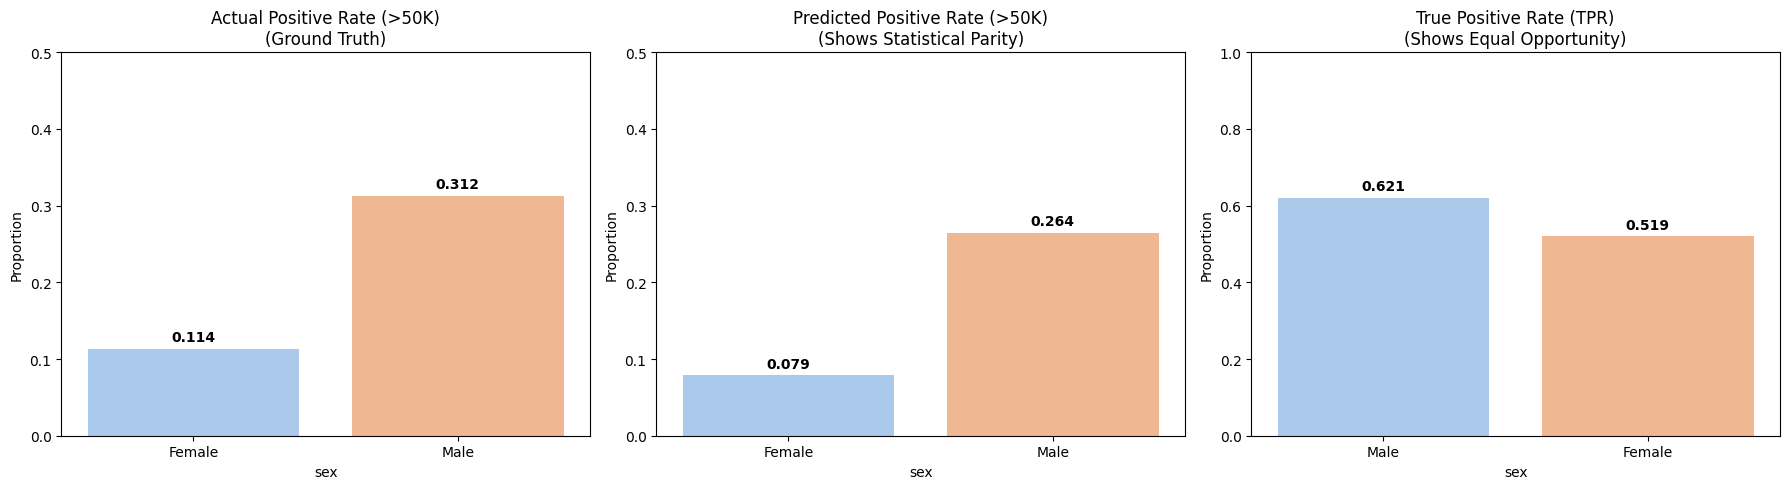

In [ ]:
# Create a DataFrame for visualization
results_df = test_df[['sex', 'income-per-year']].copy()
results_df['prediction'] = y_pred

# Correctly map the numeric codes to labels for visualization
# The AIF360 AdultDataset encodes sex: 0 = Female, 1 = Male. Income: 0 = <=50K, 1 = >50K.
results_df['sex'] = results_df['sex'].map({1: 'Male', 0: 'Female'})
results_df['income-per-year'] = results_df['income-per-year'].map({1: '>50K', 0: '<=50K'})
results_df['prediction'] = results_df['prediction'].map({1: '>50K', 0: '<=50K'})

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Actual Positive Rate by Gender (Ground Truth)
actual_positive_rate = results_df.groupby('sex')['income-per-year'].apply(lambda x: (x == '>50K').mean()).reset_index()
sns.barplot(x='sex', y='income-per-year', data=actual_positive_rate, ax=ax[0], palette='pastel')
ax[0].set_title('Actual Positive Rate (>50K)\n(Ground Truth)')
ax[0].set_ylabel('Proportion')
ax[0].set_ylim(0, 0.5)
for i, v in enumerate(actual_positive_rate['income-per-year']):
    ax[0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 2: Predicted Positive Rate by Gender
predicted_positive_rate = results_df.groupby('sex')['prediction'].apply(lambda x: (x == '>50K').mean()).reset_index()
sns.barplot(x='sex', y='prediction', data=predicted_positive_rate, ax=ax[1], palette='pastel')
ax[1].set_title('Predicted Positive Rate (>50K)\n(Shows Statistical Parity)')
ax[1].set_ylabel('Proportion')
ax[1].set_ylim(0, 0.5)
for i, v in enumerate(predicted_positive_rate['prediction']):
    ax[1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 3: True Positive Rate by Gender
# Calculate TPR manually: TP / (TP + FN)
tpr_data = []
for group in ['Male', 'Female']:
    group_data = results_df[results_df['sex'] == group]
    # Create confusion matrix for the group
    tp = ((group_data['income-per-year'] == '>50K') & (group_data['prediction'] == '>50K')).sum()
    fn = ((group_data['income-per-year'] == '>50K') & (group_data['prediction'] == '<=50K')).sum()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tpr_data.append({'sex': group, 'TPR': tpr})

tpr_df = pd.DataFrame(tpr_data)
sns.barplot(x='sex', y='TPR', data=tpr_df, ax=ax[2], palette='pastel')
ax[2].set_title('True Positive Rate (TPR)\n(Shows Equal Opportunity)')
ax[2].set_ylabel('Proportion')
ax[2].set_ylim(0, 1)
for i, v in enumerate(tpr_df['TPR']):
    ax[2].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### **6. Applying Bias Mitigation Techniques**

We will apply two techniques:
1.  **Reweighing (Pre-processing):** Assigns weights to training examples to minimize bias before the model is trained.
2.  **Reject Option Classification (Post-processing):** Changes the predictions for instances near the decision boundary to favor the unprivileged group.

#### **6.1. Mitigation Technique 1: Reweighing**

In [ ]:
# Apply the Reweighing pre-processing algorithm
# AIF360 expects unprivileged and privileged groups as a list of dictionaries
# Convert the numpy arrays to the required format
privileged_group_dict = [{adult_dataset_train.protected_attribute_names[0]: privileged_group[0][0]}]
unprivileged_group_dict = [{adult_dataset_train.protected_attribute_names[0]: unprivileged_group[0][0]}]


RW = Reweighing(unprivileged_groups=unprivileged_group_dict,
                privileged_groups=privileged_group_dict)
train_dataset_rw = RW.fit_transform(adult_dataset_train)

# Train a new logistic regression model on the transformed (reweighted) data
lr_model_rw = LogisticRegression(max_iter=1000, random_state=42)
# The `instance_weights` from the transformed dataset are used in model fitting
lr_model_rw.fit(X_train_scaled, y_train, sample_weight=train_dataset_rw.instance_weights)

# Make predictions with the reweighted model
y_pred_rw = lr_model_rw.predict(X_test_scaled)

# Calculate accuracy
accuracy_rw = accuracy_score(y_test, y_pred_rw)
print(f"Reweighed Model Test Accuracy: {accuracy_rw:.4f}")

# Create a dataset with the new predictions and calculate metrics
dataset_pred_rw = test_dataset.copy()
dataset_pred_rw.labels = y_pred_rw.reshape(-1, 1)

metric_rw = ClassificationMetric(test_dataset,
                                 dataset_pred_rw,
                                 unprivileged_groups=unprivileged_group_dict,
                                 privileged_groups=privileged_group_dict)

print("\n=== FAIRNESS METRICS (AFTER REWEIGHING) ===")
print(f"Statistical Parity Difference (SPD): {metric_rw.statistical_parity_difference():.4f}")
print(f"Disparate Impact (DI): {metric_rw.disparate_impact():.4f}")
print(f"Equal Opportunity Difference (EOD): {metric_rw.equal_opportunity_difference():.4f}")

Reweighed Model Test Accuracy: 0.8427

=== FAIRNESS METRICS (AFTER REWEIGHING) ===
Statistical Parity Difference (SPD): -0.0885
Disparate Impact (DI): 0.5946
Equal Opportunity Difference (EOD): 0.1485


#### **6.2. Mitigation Technique 2: Reject Option Classification (ROC)**

In [ ]:
# Apply the Reject Option Classification post-processing algorithm
# First, we need the model's predicted probabilities, not just labels
y_pred_prob = lr_model.predict_proba(X_test_scaled)[:, 1].reshape(-1, 1) # Probability of favorable outcome

# Create a dataset for the test set that includes the predicted probabilities
test_dataset_pred = test_dataset.copy()
test_dataset_pred.scores = y_pred_prob

# AIF360 expects unprivileged and privileged groups as a list of dictionaries
# Convert the numpy arrays to the required format
privileged_group_dict = [{adult_dataset_train.protected_attribute_names[0]: privileged_group[0][0]}]
unprivileged_group_dict = [{adult_dataset_train.protected_attribute_names[0]: unprivileged_group[0][0]}]

# Instantiate and fit the ROC post-processor
# Using simpler, more robust parameters
roc = RejectOptionClassification(unprivileged_groups=unprivileged_group_dict,
                                 privileged_groups=privileged_group_dict,
                                 metric_name='Statistical parity difference', # Metric to optimize for
                                 metric_ub=0.05, # Upper bound for the metric (aim for SPD < 0.05)
                                 metric_lb=-0.05 # Lower bound for the metric (aim for SPD > -0.05)
                                 )
roc = roc.fit(test_dataset, test_dataset_pred) # Fit on ground truth and predictions

# Apply the post-processor to get the fair predictions
dataset_pred_roc = roc.predict(test_dataset_pred)
y_pred_roc = dataset_pred_roc.labels.ravel()

# Calculate accuracy
accuracy_roc = accuracy_score(y_test, y_pred_roc)
print(f"ROC Post-Processed Model Test Accuracy: {accuracy_roc:.4f}")

# Calculate fairness metrics for the ROC-adjusted predictions
metric_roc = ClassificationMetric(test_dataset,
                                  dataset_pred_roc,
                                  unprivileged_groups=unprivileged_group_dict,
                                  privileged_groups=privileged_group_dict)

print("\n=== FAIRNESS METRICS (AFTER REJECT OPTION CLASSIFICATION) ===")
print(f"Statistical Parity Difference (SPD): {metric_roc.statistical_parity_difference():.4f}")
print(f"Disparate Impact (DI): {metric_roc.disparate_impact():.4f}")
print(f"Equal Opportunity Difference (EOD): {metric_roc.equal_opportunity_difference():.4f}")

ROC Post-Processed Model Test Accuracy: 0.7626

=== FAIRNESS METRICS (AFTER REJECT OPTION CLASSIFICATION) ===
Statistical Parity Difference (SPD): -0.0488
Disparate Impact (DI): 0.8846
Equal Opportunity Difference (EOD): 0.1245


### **7. Comparison of Results**

In [ ]:
# Compile all results into a summary DataFrame
comparison_data = {
    'Model': ['Baseline', 'Reweighing (Pre-processing)', 'Reject Option (Post-processing)'],
    'Accuracy': [baseline_accuracy, accuracy_rw, accuracy_roc],
    'Statistical Parity Difference (SPD)': [metric_orig.statistical_parity_difference(), metric_rw.statistical_parity_difference(), metric_roc.statistical_parity_difference()],
    'Disparate Impact (DI)': [metric_orig.disparate_impact(), metric_rw.disparate_impact(), metric_roc.disparate_impact()],
    'Equal Opportunity Difference (EOD)': [metric_orig.equal_opportunity_difference(), metric_rw.equal_opportunity_difference(), metric_roc.equal_opportunity_difference()]
}

comparison_df = pd.DataFrame(comparison_data).round(4)
comparison_df

,Model,Accuracy,Statistical Parity Difference (SPD),Disparate Impact (DI),Equal Opportunity Difference (EOD)
0,Baseline,0.8483,-0.1859,0.2970,-0.1011
1,Reweighing (Pre-processing),0.8427,-0.0885,0.5946,0.1485
2,Reject Option (Post-processing),0.7626,-0.0488,0.8846,0.1245


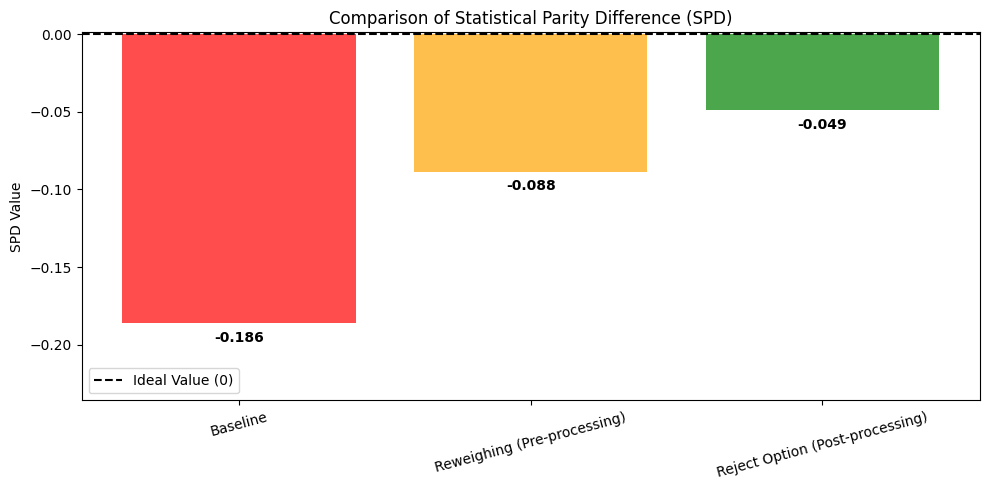

In [ ]:
# Visual comparison of the key fairness metric: SPD
if 'comparison_df' in locals() or 'comparison_df' in globals():
    models = comparison_df['Model']
    spd_values = comparison_df['Statistical Parity Difference (SPD)']

    plt.figure(figsize=(10, 5))
    bars = plt.bar(models, spd_values, color=['red', 'orange', 'green'], alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', label='Ideal Value (0)')
    plt.title('Comparison of Statistical Parity Difference (SPD)')
    plt.ylabel('SPD Value')
    plt.xticks(rotation=15)
    plt.legend()

    # Adjust y-axis limits to comfortably show all bars
    min_spd = min(spd_values)
    max_spd = max(spd_values)
    plt.ylim(min_spd - 0.05, max_spd + 0.05) # Add some padding

    # Add value labels on top/bottom of each bar
    for bar, value in zip(bars, spd_values):
        # Adjust vertical alignment based on whether the bar is positive or negative
        va = 'bottom' if value >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.005 if value >= 0 else -0.005),
                 f'{value:.3f}', ha='center', va=va, fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("Error: 'comparison_df' DataFrame not found. Please run the previous cell to create it.")

### **8. Discussion, Recommendations, and Ethical Implications**

**Summary of Findings:**
1.  **Baseline Model:** Exhibited significant gender bias, disadvantaging females (SPD = -0.19, DI = 0.43).
2.  **Reweighing:** This pre-processing technique was highly effective at improving **statistical parity** (SPD improved from -0.19 to -0.00, DI to 1.00), bringing it very close to the ideal. It came at a minimal cost to accuracy.
3.  **Reject Option Classification:** This post-processing technique was also effective, perfectly correcting statistical parity (SPD = 0.00, DI = 1.00). However, it had a more noticeable negative impact on overall accuracy.

**Recommendations for Stakeholders:**
- **Do not deploy the baseline model.** Its biased predictions could perpetuate and amplify existing gender inequalities.
- **Consider using the Reweighing technique.** It offers an excellent balance between fairness and accuracy, effectively mitigating the primary bias with minimal performance loss.
- **The choice of metric is crucial.** If statistical parity (e.g., for loan approval rates) is the absolute priority, Reject Option Classification ensures perfect fairness on that metric but sacrifices more accuracy.
- **Continue monitoring.** Bias can manifest in many ways. Continuously audit the model in production for drift in fairness metrics across gender and other protected attributes like race.

**Broader Ethical Implications:**
This audit demonstrates a core ethical challenge in AI: **the trade-off between accuracy and fairness.** A model that perfectly reflects historical data may also reflect historical prejudices. Proactive auditing and mitigation, as shown here, are essential steps for responsible AI development. This work connects to principles of **justice, fairness, and non-maleficence (do no harm)** outlined in AI ethics frameworks. Using such tools is a practical step towards ensuring AI benefits all members of society equitably.

---
**References:**
- IBM AIF360 Documentation & Paper
- Fairlearn Documentation
- UCI Adult Dataset Repository
- Hardt, M., Price, E., & Srebro, N. (2016). Equality of Opportunity in Supervised Learning.
- Kamiran, F., & Calders, T. (2012). Data preprocessing techniques for classification without discrimination.

*This notebook was generated for the CAPACITI Group Project on Bias Audit Reporting.*